In [79]:
import pandas as pd
urls_df = pd.read_csv("/Users/yitongtseo/Documents/GitHub/ethical_necromancy/nanobody_llm_refinement/5h53_HADDOCK_progress_urls.csv")
save_file = 'idx0_5h53_results.csv'# 'idx120_6ysy_results.csv'# 'idx206_8efd_results.csv' # 'idx60_6bih_results.csv' # idx0_5h53_results

# urls_df = pd.read_csv("/Users/yitongtseo/Documents/GitHub/ethical_necromancy/nanobody_llm_refinement/6ysy_HADDOCK_progress_urls.csv")
# save_file = 'idx120_6ysy_results.csv' # 'idx60_6bih_results.csv' # idx0_5h53_results


In [80]:
# conda activate ethical_necromancy
# Check here for the URLs: https://wenmr.science.uu.nl/haddock2.4/workspace

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
import requests
import re
import os
import time

import pandas as pd
import pdb

ROOT = "/Users/yitongtseo/Documents/GitHub/ethical_necromancy/nanobody_llm_refinement/Haddock_results"
# Setup DataFrame
columns = [
    "Target PDB",
    "URL",
    "Cluster ID",
    "Cluster Ranking",
    "HADDOCK score",
    "Cluster size",
    "RMSD from the overall lowest-energy structure",
    "Van der Waals energy",
    "Electrostatic energy",
    "Desolvation energy",
    "Restraints violation energy",
    "Buried Surface Area",
    "Z-Score",
    "HADDOCK Result PDB Filename",
]
if os.path.exists(save_file):
    results_df = pd.read_csv(save_file)
else:
    results_df = pd.DataFrame(columns=columns)
TOP_N_CLUSTERS = 5


chromedriver_path = "/Users/yitongtseo/Documents/GitHub/ethical_necromancy/nanobody_design_scratch/chromedriver-mac-x64/chromedriver"
service = Service(executable_path=chromedriver_path)
driver = webdriver.Chrome(service=service)

# df = pd.DataFrame()
# # URL of the page to scrape (you might need to adjust this)
# url = 'http://example.com/page'
wait = WebDriverWait(driver, 10)

for idx, row in urls_df.iterrows():
    url = row["URL"].replace("run", "result")
    print(url)
    if url in results_df['URL'].to_list():
        print('we are skipping this one! ', url)
        continue
    # Fetch the page
    driver.get(url)

    # Wait for JavaScript to load
    WebDriverWait(driver, 20).until(
        EC.visibility_of_element_located((By.CLASS_NAME, "textblock"))
    )

    # Now you can scrape the content
    clusters = driver.find_elements(By.CLASS_NAME, "textblock")

    for cluster_ranking, cluster in enumerate(clusters):
        if cluster_ranking > TOP_N_CLUSTERS:
            continue
        title = cluster.find_element(By.TAG_NAME, "p").text
        cluster_number = re.search(r"Cluster (\d+)", title)
        if cluster_number:
            cluster_number = cluster_number.group(1)
        else:
            cluster_number = "Unknown"

        cluster_data = {
            "Target PDB": url.split("-")[-1],
            "URL": driver.current_url,
            "Cluster ID": cluster_number,
            "Cluster Ranking": cluster_ranking,
        }
        print("Cluster Data:")
        # Extract cluster data
        table = cluster.find_element(By.TAG_NAME, "table")
        rows = table.find_elements(By.TAG_NAME, "tr")
        for row in rows:
            cells = row.find_elements(By.TAG_NAME, "td")
            if len(cells) == 2:
                key = cells[0].text.strip()
                value = cells[1].text.strip()
                cluster_data[key] = value
                print(f"{key}: {value}")

        driver.execute_script("arguments[0].scrollIntoView(true);", cluster)
        time.sleep(1)  # Allow some time for the browser to scroll

        dropdown = cluster.find_element(By.CLASS_NAME, "dropdown-toggle")
        ActionChains(driver).move_to_element(dropdown).click(dropdown).perform()

        # Wait for the dropdown to open and links to be visible
        try:
            wait.until(EC.visibility_of_element_located((By.LINK_TEXT, "PDB Format")))
            pdb_link = cluster.find_element(By.LINK_TEXT, "PDB Format")
            pdb_url = pdb_link.get_attribute("href")

            # Download the file
            pdb_response = requests.get(pdb_url)
            result_pdb_filename = os.path.join(
                ROOT, f"{cluster_data['Target PDB']}_cluster{cluster_ranking}.pdb"
            )
            with open(result_pdb_filename, "wb") as f:
                f.write(pdb_response.content)
            cluster_data["HADDOCK Result PDB Filename"] = result_pdb_filename

        except Exception as e:
            cluster_data["HADDOCK Result PDB Filename"] = "Failed to download"
            print(f"Error downloading: {e}")

        results_df = pd.concat(
            [results_df, pd.DataFrame([cluster_data])], ignore_index=True
        )
        print("------\n")

    results_df.to_csv(save_file, index=False)

# Close the browser
driver.quit()


https://rascar.science.uu.nl/haddock2.4/result/6886575225/385816-MyoHead_0_A102T_None
we are skipping this one!  https://rascar.science.uu.nl/haddock2.4/result/6886575225/385816-MyoHead_0_A102T_None
https://rascar.science.uu.nl/haddock2.4/result/6886575225/385817-MyoHead_0_A102R_None
we are skipping this one!  https://rascar.science.uu.nl/haddock2.4/result/6886575225/385817-MyoHead_0_A102R_None
https://rascar.science.uu.nl/haddock2.4/result/6886575225/385818-MyoHead_0_A102I_None
we are skipping this one!  https://rascar.science.uu.nl/haddock2.4/result/6886575225/385818-MyoHead_0_A102I_None
https://rascar.science.uu.nl/haddock2.4/result/6886575225/385819-MyoHead_0_L96A_None
we are skipping this one!  https://rascar.science.uu.nl/haddock2.4/result/6886575225/385819-MyoHead_0_L96A_None
https://rascar.science.uu.nl/haddock2.4/result/6886575225/385821-MyoHead_0_A102T_L114M
we are skipping this one!  https://rascar.science.uu.nl/haddock2.4/result/6886575225/385821-MyoHead_0_A102T_L114M
https

In [81]:
results_df = pd.read_csv(f'/Users/yitongtseo/Documents/GitHub/ethical_necromancy/nanobody_llm_refinement/{save_file}')

In [82]:
df_sorted = results_df.sort_values(by='Cluster Ranking', ascending=True) 
df_deduped = df_sorted.drop_duplicates(subset='Target PDB', keep='first') 
df_deduped

,Target PDB,URL,Cluster ID,Cluster Ranking,HADDOCK score,Cluster size,RMSD from the overall lowest-energy structure,Van der Waals energy,Electrostatic energy,Desolvation energy,Restraints violation energy,Buried Surface Area,Z-Score,HADDOCK Result PDB Filename
0,MyoHead_0_A102T_None,https://rascar.science.uu.nl/haddock2.4/result...,3,0,-81.6 +/- 2.5,30,8.5 +/- 0.1,-75.5 +/- 3.9,-263.1 +/- 49.7,18.6 +/- 3.9,279.6 +/- 52.8,2035.8 +/- 82.8,-1.0,/Users/yitongtseo/Documents/GitHub/ethical_nec...
36,MyoHead_0_A102V_None,https://rascar.science.uu.nl/haddock2.4/result...,1,0,-105.3 +/- 2.9,115,0.9 +/- 0.6,-96.3 +/- 6.1,-276.4 +/- 21.7,15.5 +/- 4.6,308.1 +/- 69.6,2225.5 +/- 32.1,-1.7,/Users/yitongtseo/Documents/GitHub/ethical_nec...
42,MyoHead_0_L114M_A102H,https://rascar.science.uu.nl/haddock2.4/result...,2,0,-90.4 +/- 7.3,51,3.2 +/- 0.3,-84.4 +/- 6.8,-271.3 +/- 32.5,14.7 +/- 3.4,335.8 +/- 68.2,2063.7 +/- 138.2,-1.1,/Users/yitongtseo/Documents/GitHub/ethical_nec...
48,MyoHead_0_A102T_L96A,https://rascar.science.uu.nl/haddock2.4/result...,1,0,-89.3 +/- 2.1,81,6.0 +/- 0.1,-87.5 +/- 3.0,-219.7 +/- 13.5,13.6 +/- 4.4,285.2 +/- 45.5,2266.0 +/- 26.7,-1.8,/Users/yitongtseo/Documents/GitHub/ethical_nec...
54,MyoHead_0_A102V_N100D,https://rascar.science.uu.nl/haddock2.4/result...,1,0,-101.0 +/- 4.2,95,8.4 +/- 0.0,-98.3 +/- 2.4,-299.5 +/- 43.0,23.5 +/- 1.0,336.9 +/- 41.8,2235.0 +/- 36.6,-1.8,/Users/yitongtseo/Documents/GitHub/ethical_nec...
60,MyoHead_0_N100D_L114M,https://rascar.science.uu.nl/haddock2.4/result...,1,0,-103.7 +/- 1.4,109,0.8 +/- 0.4,-94.3 +/- 6.9,-292.2 +/- 35.6,21.4 +/- 3.4,276.5 +/- 40.0,2185.6 +/- 112.0,-1.8,/Users/yitongtseo/Documents/GitHub/ethical_nec...
66,MyoHead_0_A102V_L114M,https://rascar.science.uu.nl/haddock2.4/result...,1,0,-98.0 +/- 2.7,81,1.0 +/- 0.6,-99.3 +/- 4.5,-277.9 +/- 22.5,18.7 +/- 5.3,381.7 +/- 72.0,2204.4 +/- 59.1,-1.5,/Users/yitongtseo/Documents/GitHub/ethical_nec...
72,MyoHead_0_L96A_L114M,https://rascar.science.uu.nl/haddock2.4/result...,1,0,-104.1 +/- 6.4,73,8.4 +/- 0.0,-103.1 +/- 3.0,-249.3 +/- 34.5,20.5 +/- 6.0,284.0 +/- 44.5,2280.9 +/- 110.2,-2.0,/Users/yitongtseo/Documents/GitHub/ethical_nec...
84,MyoHead_0_A102I_L96A,https://rascar.science.uu.nl/haddock2.4/result...,2,0,-100.6 +/- 4.4,47,0.5 +/- 0.4,-99.5 +/- 9.2,-241.9 +/- 52.0,16.4 +/- 4.9,308.5 +/- 34.8,2250.1 +/- 90.7,-1.5,/Users/yitongtseo/Documents/GitHub/ethical_nec...
90,MyoHead_0_L114M_None,https://rascar.science.uu.nl/haddock2.4/result...,1,0,-108.3 +/- 9.5,77,1.2 +/- 0.8,-98.0 +/- 7.3,-294.7 +/- 31.3,20.4 +/- 2.1,282.5 +/- 27.1,2189.0 +/- 67.8,-2.0,/Users/yitongtseo/Documents/GitHub/ethical_nec...


In [83]:
df_deduped['HADDOCK Result PDB Filename'].to_list()

['/Users/yitongtseo/Documents/GitHub/ethical_necromancy/nanobody_llm_refinement/Haddock_results/MyoHead_0_A102T_None_cluster0.pdb',
 '/Users/yitongtseo/Documents/GitHub/ethical_necromancy/nanobody_llm_refinement/Haddock_results/MyoHead_0_A102V_None_cluster0.pdb',
 '/Users/yitongtseo/Documents/GitHub/ethical_necromancy/nanobody_llm_refinement/Haddock_results/MyoHead_0_L114M_A102H_cluster0.pdb',
 '/Users/yitongtseo/Documents/GitHub/ethical_necromancy/nanobody_llm_refinement/Haddock_results/MyoHead_0_A102T_L96A_cluster0.pdb',
 '/Users/yitongtseo/Documents/GitHub/ethical_necromancy/nanobody_llm_refinement/Haddock_results/MyoHead_0_A102V_N100D_cluster0.pdb',
 '/Users/yitongtseo/Documents/GitHub/ethical_necromancy/nanobody_llm_refinement/Haddock_results/MyoHead_0_N100D_L114M_cluster0.pdb',
 '/Users/yitongtseo/Documents/GitHub/ethical_necromancy/nanobody_llm_refinement/Haddock_results/MyoHead_0_A102V_L114M_cluster0.pdb',
 '/Users/yitongtseo/Documents/GitHub/ethical_necromancy/nanobody_llm_ref

In [84]:
df_deduped

,Target PDB,URL,Cluster ID,Cluster Ranking,HADDOCK score,Cluster size,RMSD from the overall lowest-energy structure,Van der Waals energy,Electrostatic energy,Desolvation energy,Restraints violation energy,Buried Surface Area,Z-Score,HADDOCK Result PDB Filename
0,MyoHead_0_A102T_None,https://rascar.science.uu.nl/haddock2.4/result...,3,0,-81.6 +/- 2.5,30,8.5 +/- 0.1,-75.5 +/- 3.9,-263.1 +/- 49.7,18.6 +/- 3.9,279.6 +/- 52.8,2035.8 +/- 82.8,-1.0,/Users/yitongtseo/Documents/GitHub/ethical_nec...
36,MyoHead_0_A102V_None,https://rascar.science.uu.nl/haddock2.4/result...,1,0,-105.3 +/- 2.9,115,0.9 +/- 0.6,-96.3 +/- 6.1,-276.4 +/- 21.7,15.5 +/- 4.6,308.1 +/- 69.6,2225.5 +/- 32.1,-1.7,/Users/yitongtseo/Documents/GitHub/ethical_nec...
42,MyoHead_0_L114M_A102H,https://rascar.science.uu.nl/haddock2.4/result...,2,0,-90.4 +/- 7.3,51,3.2 +/- 0.3,-84.4 +/- 6.8,-271.3 +/- 32.5,14.7 +/- 3.4,335.8 +/- 68.2,2063.7 +/- 138.2,-1.1,/Users/yitongtseo/Documents/GitHub/ethical_nec...
48,MyoHead_0_A102T_L96A,https://rascar.science.uu.nl/haddock2.4/result...,1,0,-89.3 +/- 2.1,81,6.0 +/- 0.1,-87.5 +/- 3.0,-219.7 +/- 13.5,13.6 +/- 4.4,285.2 +/- 45.5,2266.0 +/- 26.7,-1.8,/Users/yitongtseo/Documents/GitHub/ethical_nec...
54,MyoHead_0_A102V_N100D,https://rascar.science.uu.nl/haddock2.4/result...,1,0,-101.0 +/- 4.2,95,8.4 +/- 0.0,-98.3 +/- 2.4,-299.5 +/- 43.0,23.5 +/- 1.0,336.9 +/- 41.8,2235.0 +/- 36.6,-1.8,/Users/yitongtseo/Documents/GitHub/ethical_nec...
60,MyoHead_0_N100D_L114M,https://rascar.science.uu.nl/haddock2.4/result...,1,0,-103.7 +/- 1.4,109,0.8 +/- 0.4,-94.3 +/- 6.9,-292.2 +/- 35.6,21.4 +/- 3.4,276.5 +/- 40.0,2185.6 +/- 112.0,-1.8,/Users/yitongtseo/Documents/GitHub/ethical_nec...
66,MyoHead_0_A102V_L114M,https://rascar.science.uu.nl/haddock2.4/result...,1,0,-98.0 +/- 2.7,81,1.0 +/- 0.6,-99.3 +/- 4.5,-277.9 +/- 22.5,18.7 +/- 5.3,381.7 +/- 72.0,2204.4 +/- 59.1,-1.5,/Users/yitongtseo/Documents/GitHub/ethical_nec...
72,MyoHead_0_L96A_L114M,https://rascar.science.uu.nl/haddock2.4/result...,1,0,-104.1 +/- 6.4,73,8.4 +/- 0.0,-103.1 +/- 3.0,-249.3 +/- 34.5,20.5 +/- 6.0,284.0 +/- 44.5,2280.9 +/- 110.2,-2.0,/Users/yitongtseo/Documents/GitHub/ethical_nec...
84,MyoHead_0_A102I_L96A,https://rascar.science.uu.nl/haddock2.4/result...,2,0,-100.6 +/- 4.4,47,0.5 +/- 0.4,-99.5 +/- 9.2,-241.9 +/- 52.0,16.4 +/- 4.9,308.5 +/- 34.8,2250.1 +/- 90.7,-1.5,/Users/yitongtseo/Documents/GitHub/ethical_nec...
90,MyoHead_0_L114M_None,https://rascar.science.uu.nl/haddock2.4/result...,1,0,-108.3 +/- 9.5,77,1.2 +/- 0.8,-98.0 +/- 7.3,-294.7 +/- 31.3,20.4 +/- 2.1,282.5 +/- 27.1,2189.0 +/- 67.8,-2.0,/Users/yitongtseo/Documents/GitHub/ethical_nec...


In [85]:
df_deduped["Mutations"] = df_deduped["Target PDB"].apply(
    lambda x: [mut if mut != "None" else "WT" for mut in x.split("_")[-2:]]
)

import itertools

mutations = list(set(itertools.chain(*df_deduped["Mutations"].to_list())))
mutations.remove('WT')
mutations = ['WT'] + mutations

/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_82900/164906834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deduped["Mutations"] = df_deduped["Target PDB"].apply(


In [86]:
import numpy as np
def convert_value(string_rep):
    return float(string_rep.split('+/-')[0])

matrix_df = pd.DataFrame(index=mutations, columns=mutations) 

for row in mutations: 
    for col in mutations:
        muts = df_deduped['Mutations'].to_list()
        if row == col and [row] in muts:
            matrix_df.at[row, col] = convert_value(df_deduped.iloc[muts.index([row])]['HADDOCK score'])
        elif [row, col] in muts:
            matrix_df.at[row, col] = convert_value(df_deduped.iloc[muts.index([row, col])]['HADDOCK score'])
        elif [col, row] in muts:
            matrix_df.at[row, col] = convert_value(df_deduped.iloc[muts.index([col, row])]['HADDOCK score'])
        else:
            matrix_df.at[row, col] = np.nan
matrix_df = matrix_df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
matrix_df
### 2. Populate the DataFrame Assuming you have a way to get the value for each cell (e.g., from a function or a list of values), you can then iterate over the rows and columns to fill in the DataFrame. Here, I'll provide a generic example where you manually populate the DataFrame: ```python # Example function to get values (replace with your actual method to get values) def get_value(row, col): # Replace this with your actual logic to determine the value return f"Value for ({row}, {col})" # Iterate through each row and column to populate the DataFrame for row in mutations: for col in mutations: df.at[row, col] = get_value(row, col) # Print the DataFrame print(df) ```

/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_82900/4015218892.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  matrix_df = matrix_df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))


,WT,A102R,A102V,N100D,A102I,A102T,L114M,L96A,A102H
WT,-99.0,-103.2,-105.3,-96.5,-95.0,-81.6,-108.3,-95.3,-106.8
A102R,-103.2,NaN,NaN,-98.7,NaN,NaN,-112.2,-103.6,NaN
A102V,-105.3,NaN,NaN,-101.0,NaN,NaN,-98.0,-96.4,NaN
N100D,-96.5,-98.7,-101.0,NaN,-96.2,-93.8,-103.7,-101.0,-93.3
A102I,-95.0,NaN,NaN,-96.2,NaN,NaN,-96.7,-100.6,NaN
A102T,-81.6,NaN,NaN,-93.8,NaN,NaN,-94.3,-89.3,NaN
L114M,-108.3,-112.2,-98.0,-103.7,-96.7,-94.3,NaN,-104.1,-90.4
L96A,-95.3,-103.6,-96.4,-101.0,-100.6,-89.3,-104.1,NaN,-106.9
A102H,-106.8,NaN,NaN,-93.3,NaN,NaN,-90.4,-106.9,NaN


In [87]:
upper_triangle_mask = ~np.tril(np.ones_like(matrix_df, dtype=bool), k=0)
# nan_mask = matrix_df.isnull()
# combined_mask = upper_triangle_mask & nan_mask.values
# combined_mask

In [88]:
upper_triangle_mask

array([[False,  True,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False, False,  True],
       [False, False, False, False, False, False, False, False, False]])

In [89]:
def get_label(row_idx, col_idx):
    col = matrix_df.columns[col_idx]
    row = matrix_df.index[row_idx]
    if [col, row] in df_deduped['Mutations'].to_list():
        idx = df_deduped['Mutations'].to_list().index([col, row])
    elif [row, col] in df_deduped['Mutations'].to_list(): 
        idx = df_deduped['Mutations'].to_list().index([row, col])
    else:
        return ''
    # print(f"'{df_deduped['HADDOCK Result PDB Filename'].iloc[idx]}',")
    return '\n±'.join(df_deduped['HADDOCK score'].iloc[idx].split(' +/- '))

labels_df = pd.DataFrame(index=matrix_df.index, columns=matrix_df.columns)

for row_idx in range(matrix_df.shape[0]):
    for col_idx in range(matrix_df.shape[1]):
        if upper_triangle_mask[row_idx, col_idx]:
            labels_df.iloc[row_idx, col_idx] = ''
        else:
            labels_df.iloc[row_idx, col_idx] = get_label(row_idx, col_idx)
labels_df


,WT,A102R,A102V,N100D,A102I,A102T,L114M,L96A,A102H
WT,-99.0\n±5.1,,,,,,,,
A102R,-103.2\n±3.7,,,,,,,,
A102V,-105.3\n±2.9,,,,,,,,
N100D,-96.5\n±2.0,-98.7\n±5.0,-101.0\n±4.2,,,,,,
A102I,-95.0\n±2.4,,,-96.2\n±3.9,,,,,
A102T,-81.6\n±2.5,,,-93.8\n±6.4,,,,,
L114M,-108.3\n±9.5,-112.2\n±5.9,-98.0\n±2.7,-103.7\n±1.4,-96.7\n±4.6,-94.3\n±6.8,,,
L96A,-95.3\n±1.4,-103.6\n±1.7,-96.4\n±7.1,-101.0\n±3.4,-100.6\n±4.4,-89.3\n±2.1,-104.1\n±6.4,,
A102H,-106.8\n±5.8,,,-93.3\n±4.1,,,-90.4\n±7.3,-106.9\n±5.4,


<Axes: >

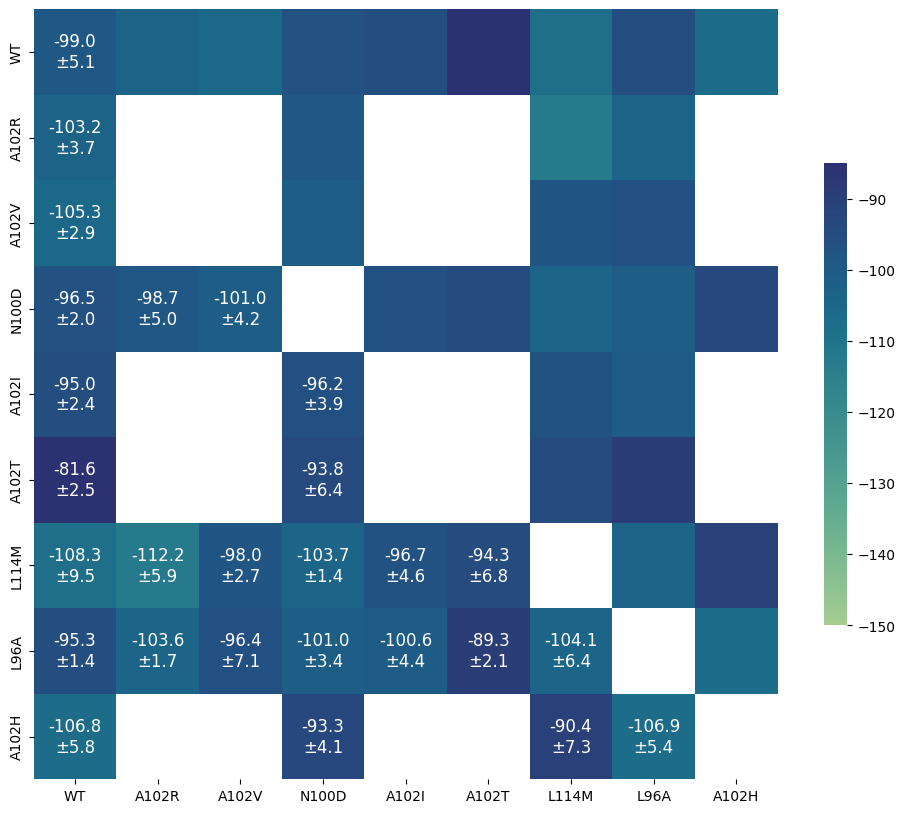

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

labels_df = labels_df.astype(str)
# Create a mask for the labels
# cmap = plt.get_cmap('YlOrRd_r').copy()
# cmap.set_bad(alpha=0.2)  # Set the alpha for masked values

# Create the masked version of your data
# masked_data = np.ma.array(matrix_df, mask=upper_triangle_mask)

# Create the masked labels
# masked_labels_df = labels_df.mask(upper_triangle_mask, '')

plt.figure(figsize=(12, 10))  # Adjust width and height as needed
sns.color_palette("crest", as_cmap=True)
cmap = sns.color_palette("crest", as_cmap=True).copy()

sns.heatmap(
    matrix_df,
    annot=labels_df,
    cbar=True,
    # mask=upper_triangle_mask,
    cbar_kws={"shrink": 0.6},
    cmap=cmap,
    xticklabels=1,
    yticklabels=1,
    fmt="",
    annot_kws={"size": 12},
    vmin=-150,  # Set the minimum value for the colorbar
    vmax=-85,
)

In [91]:
!pip install pillow matplotlib

In [92]:
def get_label(row_idx, col_idx):
    col = matrix_df.columns[col_idx]
    row = matrix_df.index[row_idx]
    if [col, row] in df_deduped['Mutations'].to_list():
        idx = df_deduped['Mutations'].to_list().index([col, row])
    elif [row, col] in df_deduped['Mutations'].to_list(): 
        idx = df_deduped['Mutations'].to_list().index([row, col])
    else:
        return ''
    return df_deduped['HADDOCK Result PDB Filename'].iloc[idx].replace('.pdb', '.png')

image_files_df = pd.DataFrame(index=matrix_df.index, columns=matrix_df.columns)

for row_idx in range(matrix_df.shape[0]):
    for col_idx in range(matrix_df.shape[1]):
        image_files_df.iloc[row_idx, col_idx] = get_label(row_idx, col_idx)

mask = np.tril(np.ones(image_files_df.shape, dtype=bool), k=-1)
# Apply the mask to set lower triangle values to empty strings
image_files_df = image_files_df.where(~mask, '')
image_files_df


,WT,A102R,A102V,N100D,A102I,A102T,L114M,L96A,A102H
WT,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...
A102R,,,,/Users/yitongtseo/Documents/GitHub/ethical_nec...,,,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...,
A102V,,,,/Users/yitongtseo/Documents/GitHub/ethical_nec...,,,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...,
N100D,,,,,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...
A102I,,,,,,,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...,
A102T,,,,,,,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...,
L114M,,,,,,,,/Users/yitongtseo/Documents/GitHub/ethical_nec...,/Users/yitongtseo/Documents/GitHub/ethical_nec...
L96A,,,,,,,,,/Users/yitongtseo/Documents/GitHub/ethical_nec...
A102H,,,,,,,,,


In [95]:
from PIL import Image
import numpy as np

def create_image_grid(df, output_filename, image_size=(800, 600)):
    rows, cols = df.shape

    # Create a blank canvas for the grid
    grid_width = cols * image_size[0]
    grid_height = rows * image_size[1]
    grid_image = Image.new('RGBA', (grid_width, grid_height), (0, 0, 0, 0))


    # Place each image into the grid
    for row in range(rows):
        for col in range(cols):
            img_file = df.iloc[row, col]
            if not os.path.exists(img_file):
                print('skipping ', img_file)
                continue
            img = Image.open(img_file).resize(image_size)
            x = col * image_size[0]
            y = row * image_size[1]
            grid_image.paste(img, (x, y))

    # Save the grid image
    grid_image.save(output_filename)

image_file = save_file.replace('.csv', '.png')
print(image_file)
create_image_grid(image_files_df, image_file, image_size=(2000, 2000))


idx0_5h53_results.png
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
skipping  
